# Plume identification in SO2 data

In [3]:
# Required imports

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import numpy as np
mpl.rcParams['figure.figsize'] = (14.0, 8.0)

First, let's load the data and do a bit of housekeeping...

In [4]:
columns = [
    "CHTSOO02", "packet length", "utc time", "ptp sync", "MFM", "flight number",
    "CPU load", "USB disc space", "cRIO temp", "conc", "pmt volt", "lamp volt",
    "lamp intens", "internal temp", "react temp", "react pressure", "flags",
    "MFC2 absolute pressure", "MFC2 temperature", "MFC2 volumetric flow",
    "MFC2 mass flow", "MFC2 setpoint", "MFC3 absolute pressure", "MFC3 temp",
    "MFC3 volumetric flow", "MFC3 mass flow", "MFC3 set point", "V6", "V7",
    "V8", "V9"
]

# Load data
data = pd.read_csv('CHTSOO02_Core_Chemistry_20211004_081257_C258.txt', names=columns, index_col='utc time')

# Drop time duplicates
data = data[~data.index.duplicated(keep='first')]

# Convert index to dates
data.index = data.index.map(datetime.datetime.utcfromtimestamp)


And plot the SO2 concentration to make sure everything look sensible...

Text(0, 0.5, 'SO2 conc.')

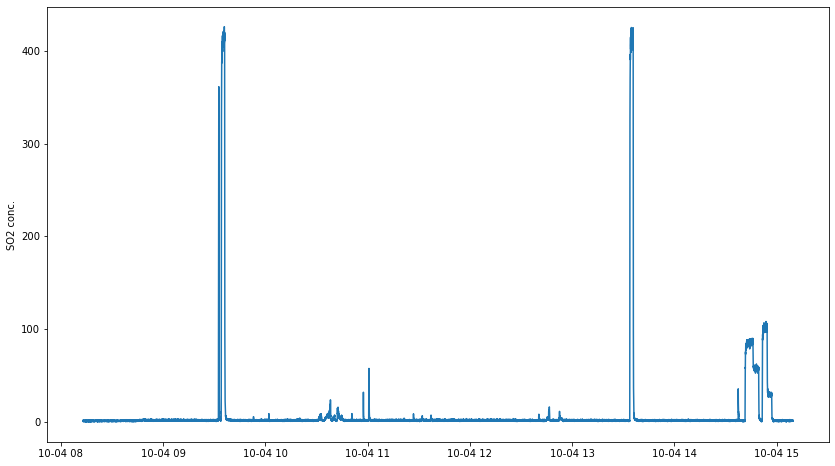

In [5]:
plt.plot(data.conc)
plt.ylabel('SO2 conc.')

We want to identify an area to use as a background. To do this we're going to

* Create a smoothed rolling average of standard deviation
* Ignore any data where this metric is above a specified value
* Use the longest continuous interval to derive background statistics

The plot below highlights in red the areas which can be considered as background

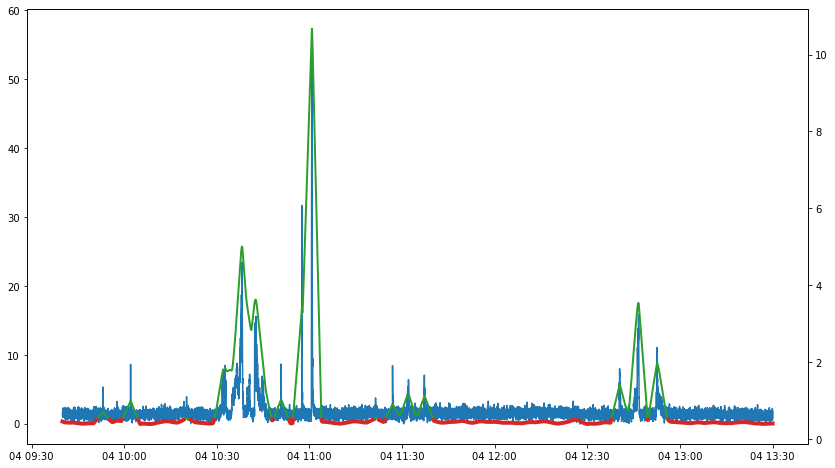

In [6]:
ROLLING_PERIOD = 180

start_time = datetime.datetime(2021,10,4,9,40,0)
end_time = datetime.datetime(2021,10,4,13,30,0)
time_filter = (data.index >= start_time) & (data.index <= end_time)
plt.plot(data.conc.loc[time_filter])

std = data.conc.rolling(ROLLING_PERIOD, center=True).std().rolling(ROLLING_PERIOD, center=True).mean().loc[time_filter]
std_low = std.copy()
std_low.loc[std_low > .5] = np.nan
plt.gca().twinx().plot(std, color='tab:green', linewidth=2)
plt.plot(std_low, 'tab:red', linewidth=4)

And we can use these to derive basic background stats, using the longest inteval, shown in magenta. The
mean and standard deviation for this period are also given

12
Background mean: 1.482753262463343
Background std: 0.4423860863864237


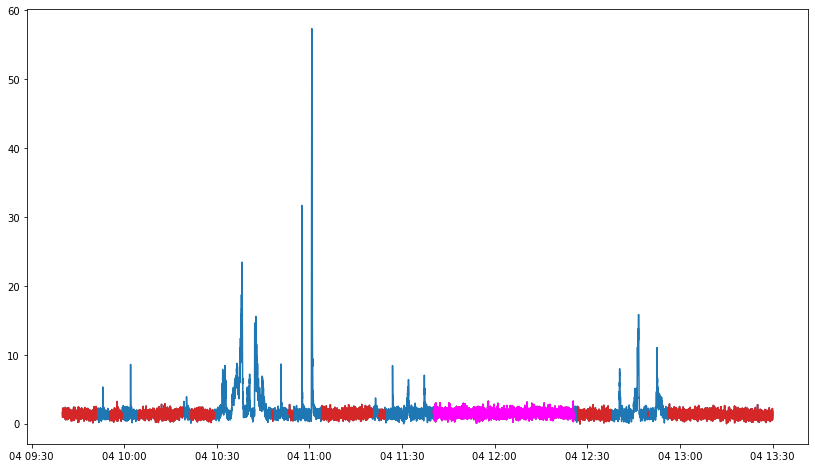

In [7]:
s = pd.DataFrame(std_low.dropna())
s['i'] = s.index.values.astype(int) / 1e9
groups = s.groupby((s.i.diff().abs() > 2).cumsum())
longest_group = sorted(groups, key=lambda x: len(x[1]))[-1]
print(len(groups))
plt.plot(data.conc[time_filter])
for group in groups:
    plt.plot(data.conc[group[1].index], color='tab:red')
plt.plot(data.conc.loc[longest_group[1].index], color='magenta')
    
bg_mean = data.conc.loc[longest_group[1].index].mean()
bg_std = data.conc.loc[longest_group[1].index].std()

print(f'Background mean: {bg_mean}')
print(f'Background std: {bg_std}')

Our first iteration of plume identification is wherever the concentration exceeds a specified number of standard deviations from the background mean.

(-1.0, 10.0)

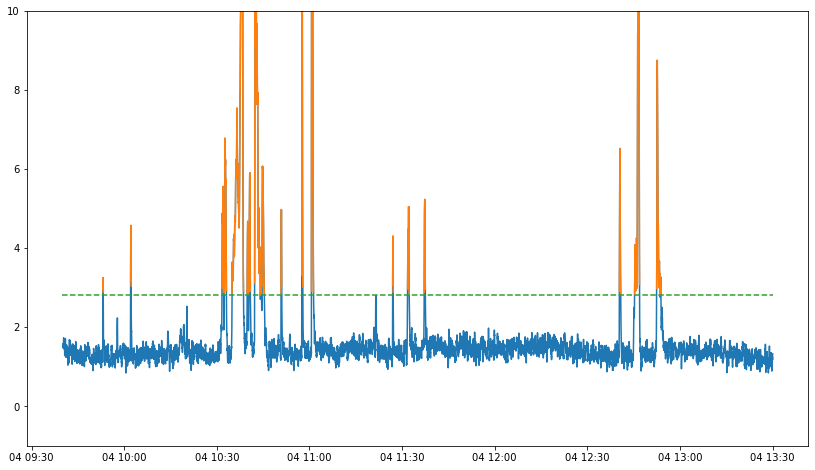

In [6]:
N_STDS = 3

conc = data.conc.loc[time_filter].rolling(10).mean()
plt.plot(conc)
conc_plume = conc.copy()
conc_plume[conc_plume < bg_mean + N_STDS*bg_std] = np.nan
plt.plot(conc_plume)
plt.plot([conc.index[0], conc.index[-1]], [bg_mean + N_STDS*bg_std]*2, '--')
plt.gca().set_ylim([-1 ,10])

We then isolate each contiguous bit of plume data

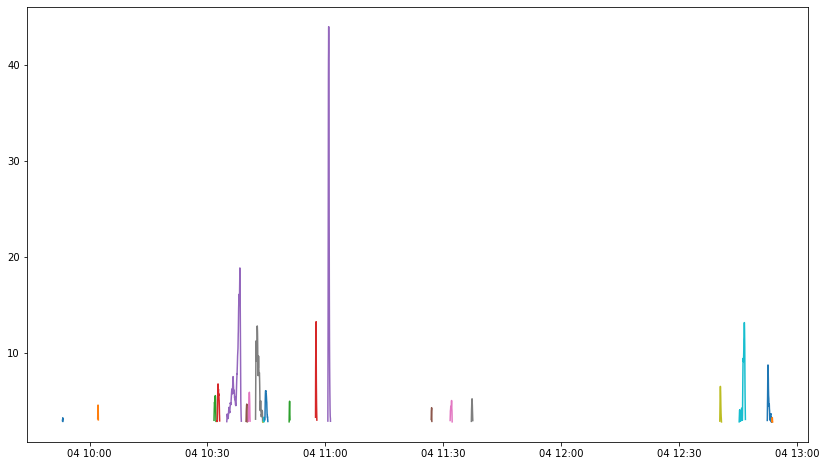

In [7]:
conc_plume = pd.DataFrame(conc_plume)
conc_plume['i'] = conc_plume.index.values.astype(int) / 1e9
groups = [
    i[1] for i in conc_plume.groupby((conc_plume.dropna().i.diff().abs() > 1).cumsum())
]

for grp in groups:
    plt.plot(grp.conc)

We then extend each of these plumes until they hit a specified number of standard deviations from the background

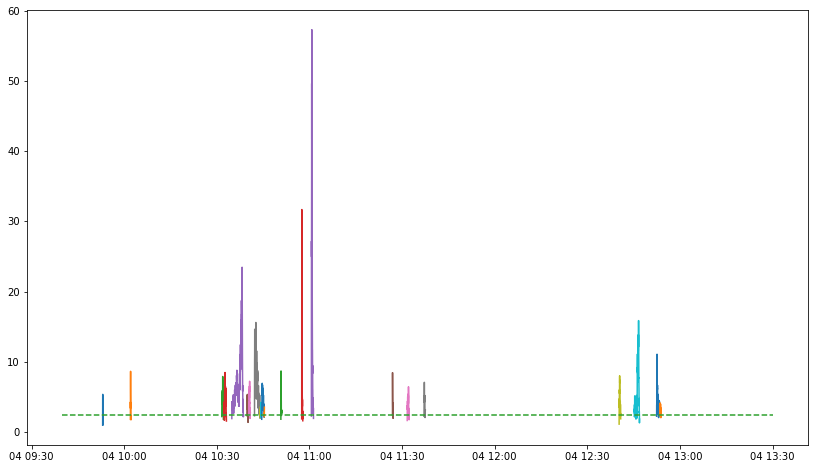

In [8]:
CUTOFF_N_STD = 2

plumes = []
for grp in groups:
    start = data.conc.loc[data.index < grp.index[0]]
    start[start > (bg_mean + CUTOFF_N_STD*bg_std)] = np.nan
    start = start.dropna().tail(1)
    plumes.append(data.conc.loc[(data.index>=start.index[0]) & (data.index<=grp.index[-1])])
    
for plume in plumes:
    plt.plot(plume)
plt.plot([conc.index[0], conc.index[-1]], [bg_mean + 2*bg_std]*2, '--')

And then add a buffer of a specified number of seconds to each plume

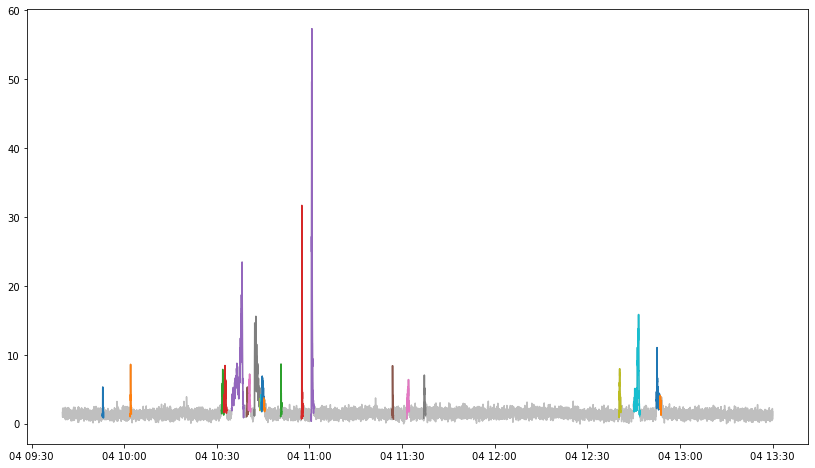

In [9]:
BUFFER_TIME = datetime.timedelta(seconds=5)

expanded_plumes = []
for plume in plumes:
    expanded_plumes.append(
        data.conc.loc[(data.index >= plume.index[0] - BUFFER_TIME) & (data.index <= plume.index[-1] + BUFFER_TIME)]
    )

plt.plot(data.conc.loc[time_filter], color='gray', alpha=.5)
for plume in expanded_plumes:
    plt.plot(plume)
    

And finally we merge any plumes which have overlapping start and end points

In [10]:
index = expanded_plumes[0].index
for plume in expanded_plumes[1:]:
    index = index.union(plume.index)

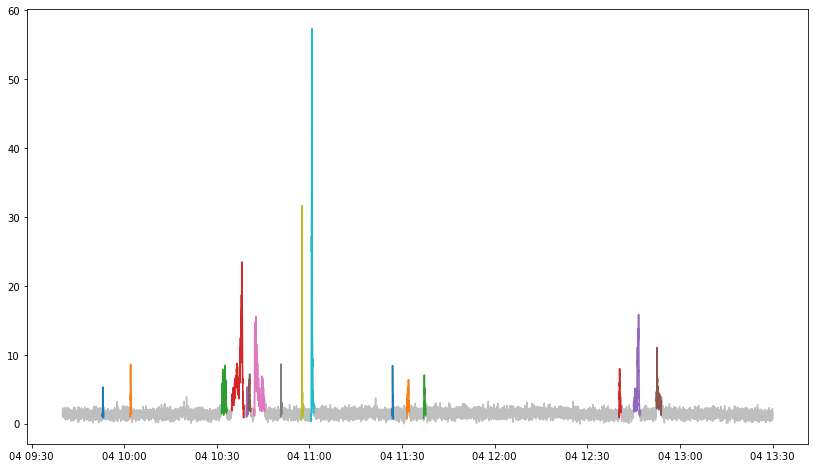

In [11]:
plumes = data.conc.copy() * np.nan
plumes.loc[index] = data.conc[index]
plumes = pd.DataFrame(plumes)
plumes['i'] = plumes.index.astype(int) / 1e9
groups = plumes.groupby((plumes.dropna().i.diff().abs() > 1).cumsum())

plt.plot(data.conc.loc[time_filter], color='gray', alpha=.5)
for group in groups:
    plt.plot(group[1].conc)

We can sum each plume to pretend we're integrating

In [12]:
for grp in groups:
    i, df = grp
    print(f'plume {int(i)+1}: {df.index[0]} - {df.index[-1]} -> {df.conc.sum()}')

plume 1: 2021-10-04 09:52:56 - 2021-10-04 09:53:17 -> 48.57550000000001
plume 2: 2021-10-04 10:01:55 - 2021-10-04 10:02:19 -> 72.16659999999999
plume 3: 2021-10-04 10:31:31 - 2021-10-04 10:33:11 -> 409.95700000000005
plume 4: 2021-10-04 10:34:46 - 2021-10-04 10:38:42 -> 1590.8176999999996
plume 5: 2021-10-04 10:39:38 - 2021-10-04 10:40:13 -> 110.784
plume 6: 2021-10-04 10:40:15 - 2021-10-04 10:40:56 -> 159.607
plume 7: 2021-10-04 10:42:07 - 2021-10-04 10:45:29 -> 1118.851
plume 8: 2021-10-04 10:50:39 - 2021-10-04 10:51:05 -> 83.209
plume 9: 2021-10-04 10:57:24 - 2021-10-04 10:57:55 -> 183.8227
plume 10: 2021-10-04 11:00:32 - 2021-10-04 11:01:23 -> 776.4157000000001
plume 11: 2021-10-04 11:26:48 - 2021-10-04 11:27:11 -> 64.91059999999999
plume 12: 2021-10-04 11:31:34 - 2021-10-04 11:32:21 -> 168.8558
plume 13: 2021-10-04 11:37:00 - 2021-10-04 11:37:36 -> 128.4178
plume 14: 2021-10-04 12:40:12 - 2021-10-04 12:40:53 -> 154.2737
plume 15: 2021-10-04 12:45:06 - 2021-10-04 12:46:58 -> 610.59

And here's a quick and dirty plot against CO2....

In [13]:
columns = [
    "CHFGGA02", "packet length", "utc time", "ptp sync", "flight number", "CPU load",
    "USB disc space", "cRIO temp", "CH4", "CO2", "H20", "pressure", "temp",
    "fit flag", "rda usec", "rdb usec", "CH4 dry", "CO2 dry", "amb temp",
    "MFC1 absolute pressure", "MFC1 temperature", "MFC1 volumetric flow",
    "MFC1 mass flow", "MFC1 setpoint", "V1", "V2", "V3", "V4", "FGGA pump",
    "V10", "CC2PUMP", "MFC4 absolute pressure", "MFC4 temp", "MFC4 volumetric flow",
    "MFC4 mass flow", "MFC4 set point", "PPT2 pressure", "PPT2 temp",
    "APR valve percent", "APR press stpt percent", "APR press percent"
]

# Load data
chf = pd.read_csv('CHFGGA02_Core_Chemistry_20211004_081257_C258.txt', names=columns, index_col=2)

# Drop time duplicates
chf = chf[~chf.index.duplicated(keep='first')]

# Convert index to dates
chf.index = chf.index.map(datetime.datetime.utcfromtimestamp)

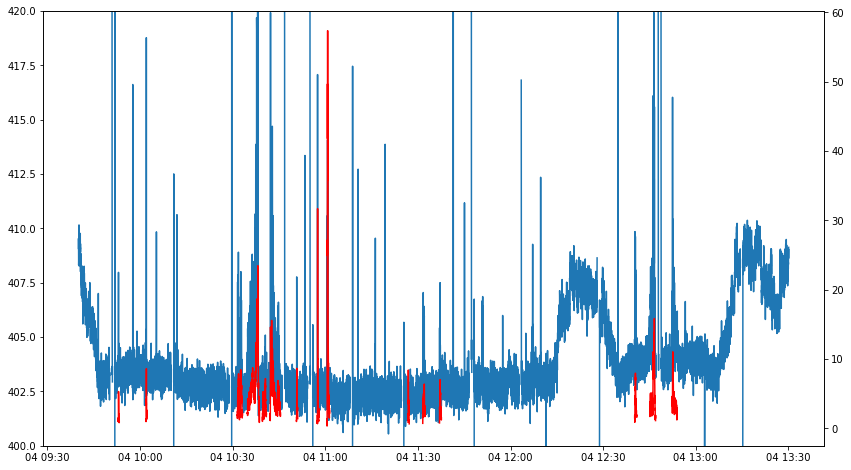

In [14]:
co2_timef = (chf.index >= start_time) & (chf.index <= end_time)
chf[chf.V1==1] = np.nan
chf.index += datetime.timedelta(seconds=4)
plt.plot(chf.CO2.loc[co2_timef])
plt.gca().set_ylim([400, 420])
ax = plt.gca().twinx()
for group in groups:
    ax.plot(group[1].conc, 'r')

In [2]:
import pandas as pd
pd.__version__

'1.4.0'